# UMAP and clustering


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cv2
import skimage
import tifffile as tf
import os
import pandas as pd
#import napari
#print(napari.__version__)
#from dask_image.imread import imread
#import dask.array as da
#import io

import platform
if platform.system() == 'Windows':
    fileroot = 'X:/'
    print('Loading Windows')
if platform.system() == 'Linux':
    fileroot = '/home/jovyan/'
    print('Loading Linux')
if False:
    fileroot = '/home/ubuntu/Documents/'
if os.path.exists('/nfs/team283_imaging/') and not os.path.exists('/home/jovyan/'):
    fileroot = '/nfs/team283_imaging/'

colors_new=['#0072b2','#d55e00','#009e73', '#cc79a7','#f0e442','#56b4e9']

import sys
sys.path.append(fileroot+'VU_TEX/Ben_utilities/')
import useful_functions as uf
import numba_funcs as nf

Loading Linux


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib.colors import to_rgba
#import hdbscan
import umap
from tqdm import tqdm, trange
import fastremap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from numba import njit
import scipy
import pickle

In [3]:
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 100)

### Load data

In [5]:
#directory_images_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
directory_images_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_images_metadata = '2022-09-01_IVY_GAP_metadata.csv'
df_images_metadata = pd.read_csv(directory_images_metadata + filename_images_metadata, index_col=0)
df_images_metadata = df_images_metadata.loc[df_images_metadata['original_index'].isin([50, 594, 406, 418, 
267, 290, 474, 231, 498, 217, 
309, 544])]
df_images_metadata

,original_index,annotated,output_filename,output_filename_annotations,bits_per_component,data_set_id,expression_x,height,subimage_id,image_height,image_type,image_width,lims1_id,number_of_components,path,resolution,section_number,structure_id_x,tier_count,width,x,y,failed_facet,section_data_set_id,plane_of_section_id,qc_date,section_thickness,specimen_id,sphinx_id_x,storage_directory,weight_x,donor_id,name_x,rna_integrity_number,hemisphere,structure_id_y,parent_id,parent_x_coord,parent_y_coord,parent_z_coord,external_specimen_name,specimen_id_path,is_ish,sphinx_id_y,weight_y,is_cell_specimen,name_y,age_id,organism_id,strain,sex,condition_description,external_donor_name,sex_full_name,tags,multifocal,recurrence_by_six_months,race_only,donor_sex_facet,donor_strain_facet,donor_race_only_facet,donor_condition_description_facet,primary_tissue_source,chemotherapy,egfr_amplification,extent_of_resection,mgmt_methylation,pten_deletion,radiation_therapy,tumor_status,initial_kps,time_to_progression_or_recurrence,mgmt_ihc,survival_days,molecular_subtype
50,50,False,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...,8.0,273294277,NaN,18080,273294441,44736,Primary,81664,NaN,3.0,/external/gbm/prod1/0534343071/0534343071.aff,0.4945,5,NaN,10,15040,9152,1856,734881840,273294277,7,2013-11-27T18:09:40Z,20.0,268416305,137495,/external/gbm/prod8/image_series_273294277/,5040,12106,H366-0019a.06.A.01,NaN,right,4009,705755,1,1,1,W4-1-1-F.1.01,/705727/705755/268416305/,t,511238,9000,f,H366-0019,79,1,unknown,F,"Survival (in days, integer) Radiationtherapy -...",W4-1-1,Female,H366-0019,No,Yes,unknown,1306038106,2.904992e+09,2.904992e+09,3298293420,Swedish,Yes,No,Complete,No,Yes,Yes,primary,90,102.0,80.0,540.0,"Mesenchymal, Neural"
217,217,True,donor_id_12165_specimen_id_706867_subimage_id_...,donor_id_12165_specimen_id_706867_subimage_id_...,8.0,300631275,False,18048,300631309,29632,Primary,49792,NaN,3.0,/external/gbm/prod3/0539028775_300197737/05390...,0.4945,62,NaN,9,15104,5888,5632,734881840,300631275,9,2014-05-05T17:19:49Z,14.0,706867,110034,/external/gbm/prod21/image_series_300631275/,5190,12165,H366-0029a.04.B.05,NaN,right,4132,706198,5,1,1,W12-1-1-D.2.05,/706190/706198/706867/,t,511657,9000,f,H366-0029,86,1,unknown,F,disease categories - glioblastoma Survival (in...,W12-1-1,Female,H366-0029,No,unknown,unknown,1306038106,2.904992e+09,2.904992e+09,3617011942,Swedish,No,Yes,Sub-total,No,No,No,primary,70,7.0,20.0,80.0,Classical
231,231,False,donor_id_12111_specimen_id_301589924_subimage_...,donor_id_12111_specimen_id_301589924_subimage_...,8.0,302049403,False,18048,302049407,29376,Primary,49792,NaN,3.0,/external/gbm/prod4/0539000884_301628602/05390...,0.4994,294,NaN,9,15104,8064,5632,734881840,302049403,7,2014-07-18T20:42:17Z,14.0,301589924,10192,/external/gbm/prod21/image_series_302049403/,5190,12111,H366-0025a.05.B.03,NaN,left,4084,705834,3,1,1,W10-1-1-E.2.03,/705810/705834/301589924/,t,511394,9000,f,H366-0025,42,1,unknown,F,disease categories - glioblastoma EGFR amplifi...,W10-1-1,Female,H366-0025,No,unknown,unknown,1306038106,2.904992e+09,2.904992e+09,699970192,Swedish,Yes,No,Complete,Yes,No,Yes,primary,100,NaN,0.0,NaN,Proneural
267,267,False,donor_id_12108_specimen_id_298804531_subimage_...,donor_id_12108_specimen_id_298804531_subimage_...,8.0,309715108,False,18048,309715132,46176,Primary,101568,NaN,3.0,/external/gbm/prod8/0539009622_308999323/05390...,0.4970,23,NaN,10,15104,43520,4480,734881840,309715108,8,2014-10-27T20:54:33Z,20.0,298804531,142160,/external/gbm/prod21/image_series_309715108/,5040,12108,H366-0023a.07.B.02,NaN,left,4084,705784,2,1,1,W8-1-1-G.2.02,/705757/705784/298804531/,t,511306,9000,f,H366-0023,26,1,unknown,F,Tumor status - primary PTEN deletion - No EGFR...,W8-1-1,Female,H366-0023,Yes,Yes,unknown,1306038106,2.904992e+09,2.904992e+09,2799164948,Swedish,Yes,No,Complete,No,No,Yes,primary,70,29.0,20.0,442.0,"Classical, Mesenchymal"
290,290,False,donor_id_12111_specimen_id_310607296_

In [6]:
#directory_colors_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
directory_colors_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_colors_metadata = '2022-09-02_colors_for_IVY_GAP.csv'
df_colors = pd.read_csv(directory_colors_metadata + filename_colors_metadata, index_col=0)
df_colors

,color_indices,colors_hex,colors_rgb255,region_names,official_region_names,colorblind_safe,colorblind_optimized
0,0,#FFFFFF,"(255, 255, 255)",Background,Bg,#800080,#ff9999
1,1,#218FA5,"(33, 143, 165)",Leading Edge,LEregion,#218FA5,#006400
2,2,#D104D0,"(209, 4, 208)",Infiltrating Tumor,ITregion,#D104D0,#ff1493
3,3,#05D004,"(5, 208, 4)",Cellular Tumor,CTregion,#05D004,#a6730a
4,4,#FF6600,"(255, 102, 0)",Hyperplastic blood vessels,LE_IT_CT_hbv,#FF6600,#ff8c00
5,5,#43D1F8,"(67, 209, 248)",Perinecrotic zone,CTpnz,#43D1F8,#00bfff
6,6,#0504D0,"(5, 4, 208)","Pseudopalisading cells, no necrosis",CTpnn,#0504D0,#0000ff
7,7,#05D0AA,"(5, 208, 170)","Pseudopalisading cells, around necrosis",CTpan,#05D0AA,#ffd700
8,8,#FF3300,"(255, 51, 0)",Microvascular proliferation,CTmvp,#006400,#800080
9,9,#060505,"(6, 5, 5)",Necrosis,CTne,#060505,#000054


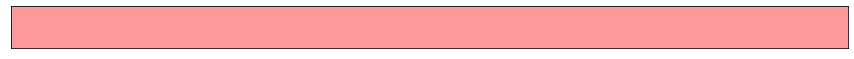

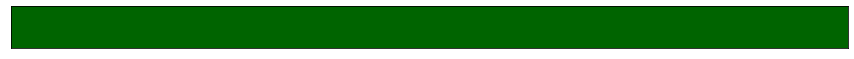

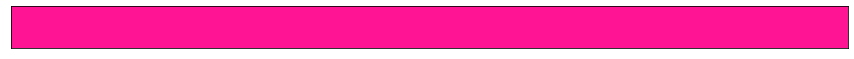

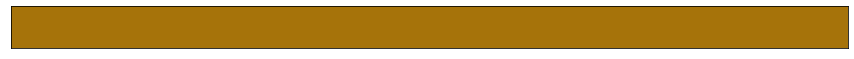

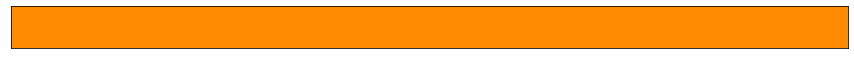

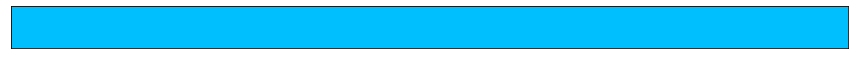

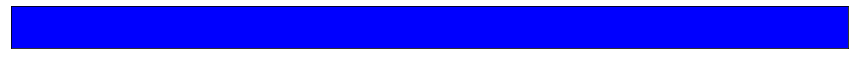

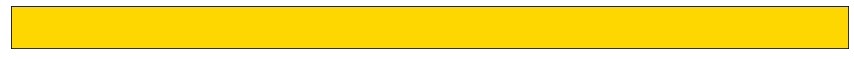

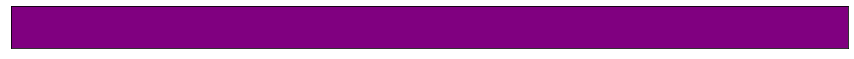

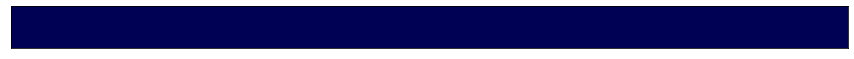

In [7]:
for i, each in enumerate(df_colors['colorblind_optimized']):
#    print(i)
    uf.make_Ramp_flexible([each, each])
    plt.show()

In [8]:
mycolors = list(df_colors['colorblind_optimized'])

In [9]:
#directory_X = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
#filename_X = '2022-10-13_LBP_all_images_data_X_up_to_radius_34.npy'
#X = np.load(directory_X + filename_X, mmap_mode='r')

In [10]:
directory_X_scaled = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
#directory_X_scaled = '/lustre/scratch117/cellgen/team283/bw17/VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
filename_X_scaled = '2022-11-09_LBP_all_images_data_X.npy'
X = np.load(directory_X_scaled + filename_X_scaled, mmap_mode='r')
X.shape, X.dtype

((80540, 9416), dtype('uint16'))

In [11]:
start = datetime.now(); print(start)
directory_OBS = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
filename_OBS = '2022-11-09_LBP_all_images_data_OBS.csv'
df_OBS = pd.read_csv(directory_OBS + filename_OBS, index_col=0)
df_OBS['Groundtruth'] = pd.Categorical(df_OBS['Groundtruth'])
df_OBS['original_index'] = pd.Categorical(df_OBS['original_index'])
display(df_OBS)
datetime.now()-start

2022-11-10 09:51:50.918214


,this_image_index,X0,X1,Groundtruth,original_index,output_filename,output_fname_annotated
0,0,0,0,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
1,1,0,1,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
2,2,0,2,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
3,3,0,3,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
4,4,0,4,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
...,...,...,...,...,...,...,...
80535,6745,89,70,3,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80536,6746,89,71,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80537,6747,89,72,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80538,6748,89,73,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...


datetime.timedelta(microseconds=131907)

In [12]:
pd.unique(df_OBS['original_index'])

[50, 217, 231, 267, 290, ..., 418, 474, 498, 544, 594]
Length: 12
Categories (12, int64): [50, 217, 231, 267, ..., 474, 498, 544, 594]

In [13]:
directory_VAR = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
filename_VAR = '2022-11-09_LBP_all_images_data_VAR.csv'
df_VAR = pd.read_csv(directory_VAR + filename_VAR, index_col=0)
df_VAR.index = df_VAR.index.astype(str)
df_VAR

,0
0,Ch_0_METHOD_uniform_npoints_7_radius_1_value_0
1,Ch_0_METHOD_uniform_npoints_7_radius_1_value_1
2,Ch_0_METHOD_uniform_npoints_7_radius_1_value_2
3,Ch_0_METHOD_uniform_npoints_7_radius_1_value_3
4,Ch_0_METHOD_uniform_npoints_7_radius_1_value_4
...,...
9411,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9412,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9413,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9414,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...


In [14]:
dict_colors = {0:to_rgba(mycolors[0]), 
               1:to_rgba(mycolors[1]), 
               2:to_rgba(mycolors[2]),
               3:to_rgba(mycolors[3]),
               4:to_rgba(mycolors[4]),
               5:to_rgba(mycolors[5]),
               6:to_rgba(mycolors[6]),
               7:to_rgba(mycolors[7]),
               8:to_rgba(mycolors[8]),
               9:to_rgba(mycolors[9]),
              np.nan:(1, 1, 1)
              }

dict_color_names = {0:mycolors[0], 
               1:mycolors[1], 
               2:mycolors[2],
               3:mycolors[3],
               4:mycolors[4],
                5:mycolors[5],
               6:mycolors[6],
                7:mycolors[7],
               8:mycolors[8],
                  9:mycolors[9],  
              np.nan:(1, 1, 1)
                   }

#mycolors_list_all = anndata_concat.obs['Groundtruth'].map(dict_color_names)
#mycolors_list_all_ilastik = df_all['Pathology'].map(dict_color_names)
#mycolors_list_all

  0%|                                                    | 0/12 [00:00<?, ?it/s]

5313


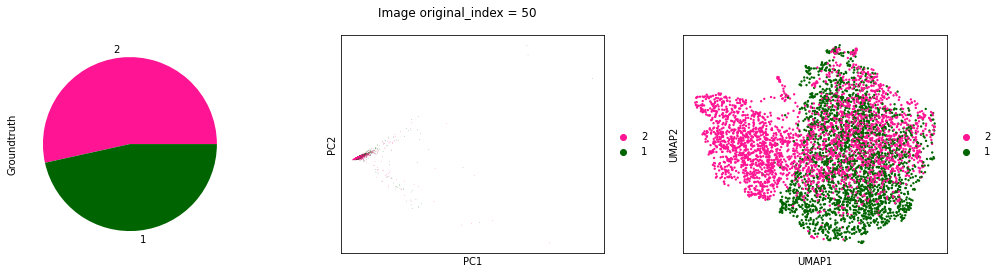

  8%|███▋                                        | 1/12 [00:12<02:12, 12.03s/it]

6161


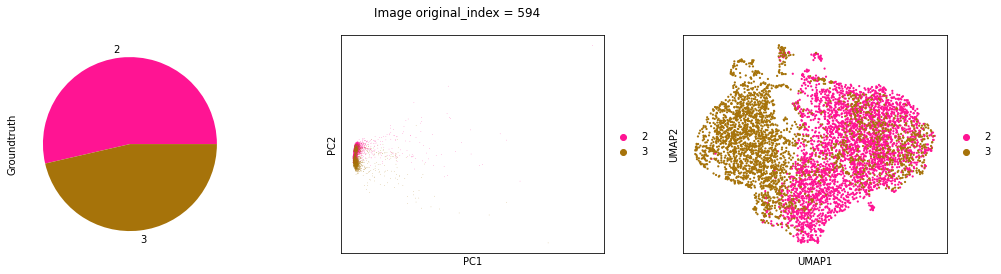

 17%|███████▎                                    | 2/12 [00:21<01:47, 10.70s/it]

6016


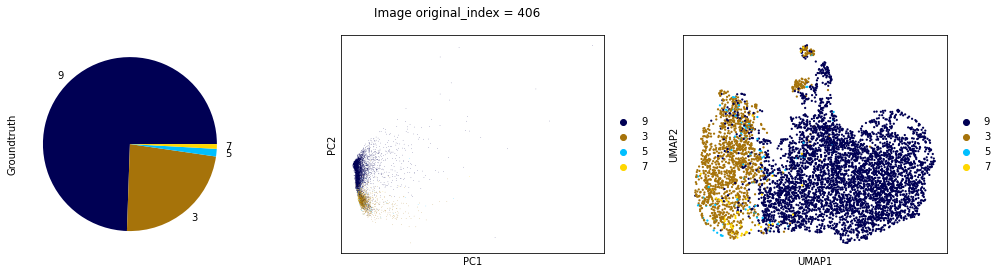

 25%|███████████                                 | 3/12 [00:33<01:38, 10.95s/it]

5621


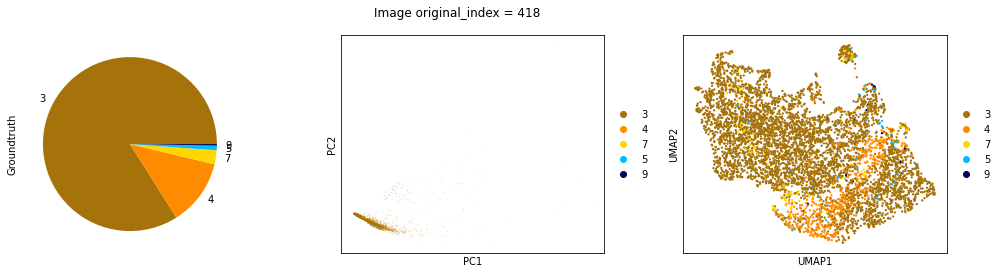

 33%|██████████████▋                             | 4/12 [00:43<01:25, 10.73s/it]

6183


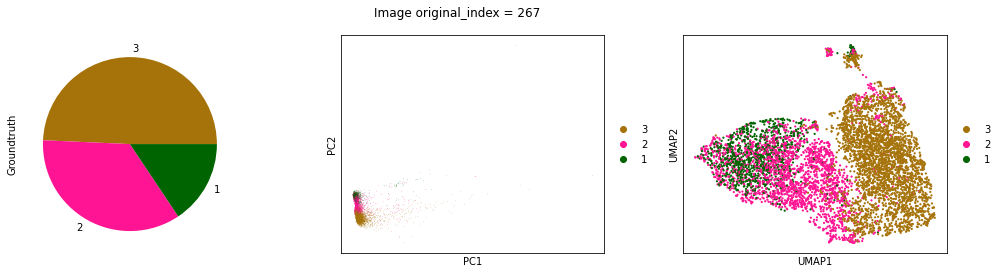

 42%|██████████████████▎                         | 5/12 [00:53<01:14, 10.62s/it]

5900


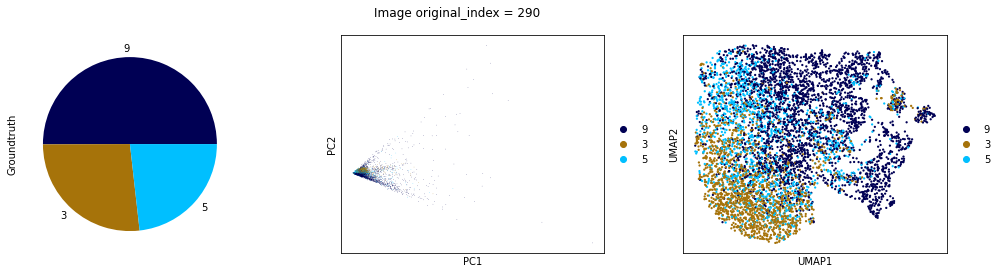

 50%|██████████████████████                      | 6/12 [01:03<01:02, 10.44s/it]

6425


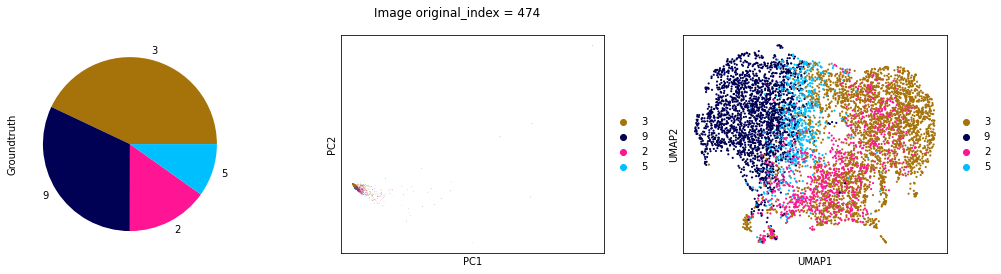

 58%|█████████████████████████▋                  | 7/12 [01:14<00:51, 10.32s/it]

5542


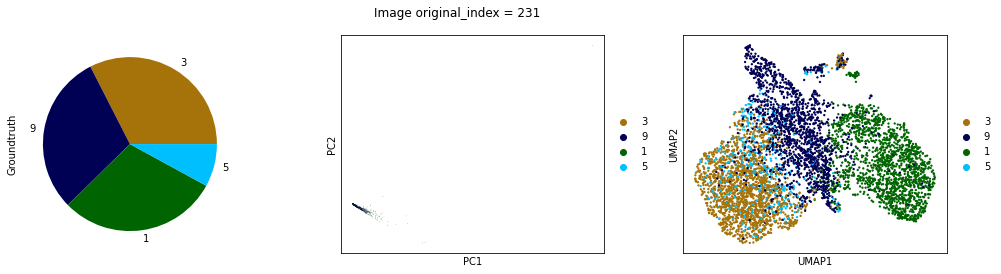

 67%|█████████████████████████████▎              | 8/12 [01:24<00:41, 10.31s/it]

6464


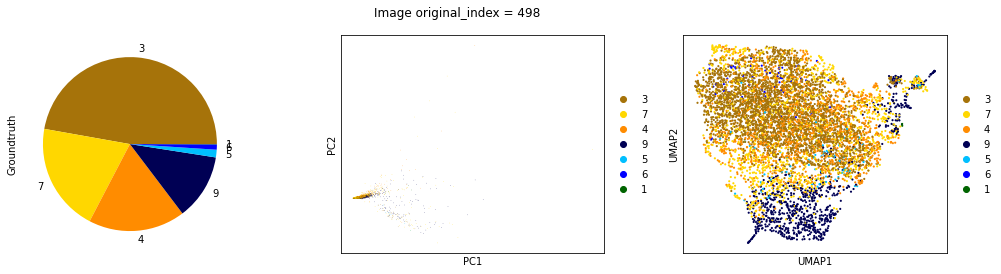

 75%|█████████████████████████████████           | 9/12 [01:35<00:31, 10.54s/it]

4953


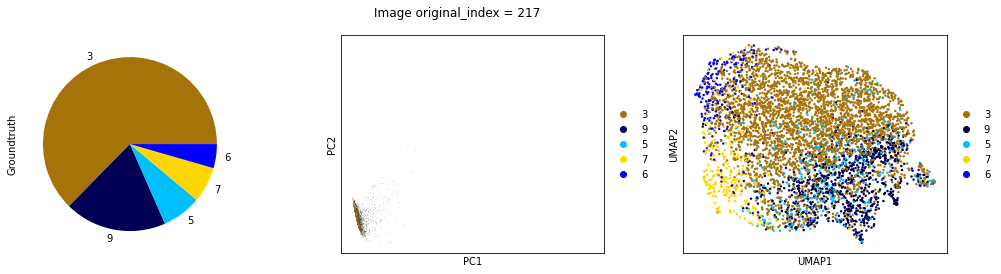

 83%|███████████████████████████████████▊       | 10/12 [01:44<00:20, 10.17s/it]

6119


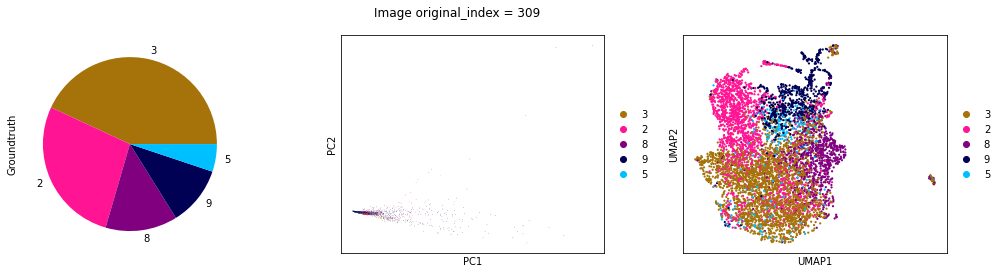

 92%|███████████████████████████████████████▍   | 11/12 [01:55<00:10, 10.36s/it]

4929


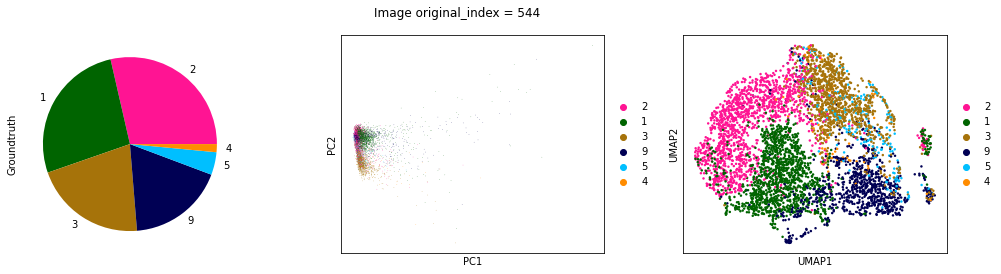

100%|███████████████████████████████████████████| 12/12 [02:04<00:00, 10.35s/it]


In [15]:
for img_original_index in tqdm([50, 594, 406, 418, 267, 290, 474, 231, 498, 217, 309, 544]):
    list_of_index_img0 = df_OBS.index[(df_OBS['original_index'].isin([img_original_index])) &
                                 (~df_OBS['Groundtruth'].isin([0]))]
    print(len(list_of_index_img0))
    this_df = df_OBS.loc[list_of_index_img0]
    this_df.index = this_df.index.astype(str)
    anndata_concat = ad.AnnData(X=X[list_of_index_img0], obs=this_df, var=df_VAR, dtype=np.float32)
    Groundtruth_vc = anndata_concat.obs['Groundtruth'].value_counts()
    anndata_concat.obs['Groundtruth'] = anndata_concat.obs['Groundtruth'].cat.set_categories(list(Groundtruth_vc.index[Groundtruth_vc > 0]))
    sc.pp.scale(anndata_concat)
    
    z = [dict_colors[each] for each in list(anndata_concat.obs['Groundtruth'].value_counts().index)]
    fig, ax = plt.subplots(1,3, figsize=(17,4))
    Groundtruth_vc.plot(kind='pie', colors=z, ax=ax[0])
    sc.tl.pca(anndata_concat, svd_solver='auto')
    sc.pl.pca(anndata_concat, color='Groundtruth',
                 size=1, palette=dict_colors, components=['1,2'], ax=ax[1], show=False, title='')
    sc.pp.neighbors(anndata_concat, n_neighbors=5, n_pcs=None)
    sc.tl.umap(anndata_concat) #, min_dist=0.0
    sc.pl.umap(anndata_concat, color=['Groundtruth'],          
         palette=dict_colors, show=False, alpha=1, ax=ax[2], title='')
    plt.suptitle('Image original_index = ' + str(img_original_index))
    plt.subplots_adjust(wspace=0.3)
    plt.show()
#    break